# Surface Projection

We explore the toy example of learning a surface, represented by a set of 3D points $\{(x_i, y_i, z_i) \in \mathbb{R}^3 \mid i = 1, \ldots, m\}$, such that the projection of the surface onto the nearest ellipsoid has maximum volume (area in 2D) and unit surface area (circumference in 2D). We know that the solution to such a problem is a sphere. We will now extend our 2D problem into 3D but maintain that the ellipsoid is axis-aligned and represent it by the length of each axis $a$, $b$, and $c$. Given this representation the volume of the ellipsoid is

$$
V = \frac{4}{3} \pi a b c
$$

and surface area approximated by

$$
S \approx 4 \pi \sqrt[p]{\frac{a^pb^p + a^pc^p + b^pc^p}{3}},
$$
where $p\approx 1.6075$ yields a relative error of at most 1.061%.
Full details and other approximations are discussed on [Wikipedia](https://en.wikipedia.org/wiki/Ellipsoid).

## Projection onto constrained ellipsoid

The nearest ellipsoid (parametrized by $(a, b, c)$), with unit surface area, to the set of points $\{(x_i, y_i, z_i)\}$ can be found in the least-squares sense,

$$
\begin{array}{ll}
  \text{minimize (over $a, b, c$)} & \sum_{i=1}^{m} \left(\frac{x_i^2}{a^2} + \frac{y_i^2}{b^2} + \frac{z_i^2}{c^2} - 1\right)^2 \\
  \text{subject to} & 4 \pi \sqrt[p]{\frac{(ab)^p + (ac)^p + (bc)^p}{3}} = 1
\end{array}
$$

which can be written in standard form as

$$
\begin{array}{ll}
  \text{minimize} & \|A u - \mathbf{1}_m\|^2 \\
  \text{subject to} & 4 \pi \sqrt[p]{\frac{1}{3} \left[ \left(\frac{1}{\sqrt{u_1u_2}}\right)^p + \left(\frac{1}{\sqrt{u_1u_3}}\right)^p + \left(\frac{1}{\sqrt{u_2u_3}}\right)^p \right]  } = 1
\end{array}
$$

where

$$
A = \begin{bmatrix}
  x_1^2 & y_1^2 & z_1^2 \\
  \vdots & \vdots & \vdots \\
  x_m^2 & y_m^2 & z_m^2
\end{bmatrix}
$$

and $u = \left(\frac{1}{a^2}, \frac{1}{b^2}, \frac{1}{c^2}\right)^\top$.


## Bilevel optimization

Our overall problem can then be stated as

$$
\begin{array}{ll}
  \text{minimize (over $\{(x_i, y_i)\}$)} & \sqrt{u_1^\star u_2^\star u_3^\star} \\
  \text{subject to} & u^\star = \text{argmin} \; \|Au - \mathbf{1}_m\|^2 \\
  & \hphantom{y =} \text{subject to} \; 4 \pi \sqrt[p]{\frac{1}{3} \left[ \left({\sqrt{u_1}}\right)^p + \left({\sqrt{u_2}}\right)^p + \left({\sqrt{u_3}}\right)^p \right]  } - \sqrt{u_1u_2u_3} = 0
\end{array}
$$

where we have stated the lower-level problem in terms of $u$ rather than $(a, b, c)$, and therefore instead of maximizing $\frac{4}{3} \pi a b c$, we minimize $\sqrt{u_1 u_2 u_2} = \frac{1}{abc}$.

Ellipsoid (blue) (0.25, 0.1, 0.4) has volume 0.0419 and surface area 0.76.
tensor([  8.8467, 103.7083,   5.9384], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
Ellipsoid (red) estimate (0.336, 0.0982, 0.41) has volume 0.0567 and surface area 1.0.


/var/folders/5f/p7wxm9ss4y79jh19st9d10h80000gn/T/ipykernel_63917/869762579.py:46: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  u0 = np.linalg.lstsq(A, b)[0]


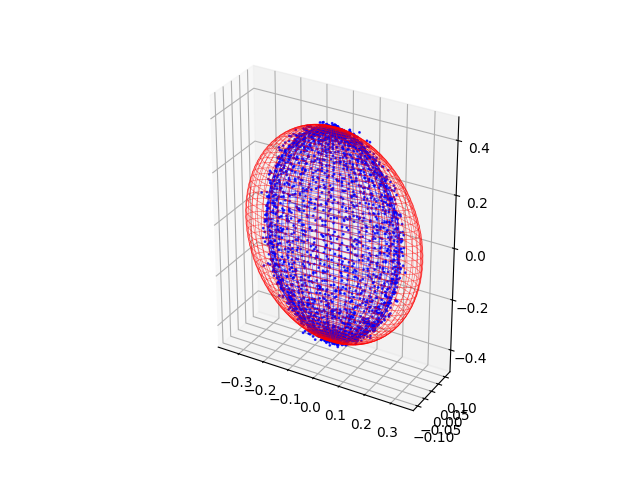

In [8]:
import math
import numpy as np
import scipy.optimize as opt
import torch
import torch.nn as nn
%matplotlib ipympl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import warnings
# warnings.filterwarnings('ignore')

# ellipse area and circumferencce
def ellipsoid_volume(a, b,c):
    """Returns the volume of an ellipsoid parametrized as (x/a)^2 + (y/b)^2 + (z/c)^2 = 1."""
    return 4/3 * math.pi * a * b * c

def ellipsoid_surface_area(a, b, c, p=1.6075):
    """Returns the approximate surface area of an ellipsoid."""
    a_p = a**p
    b_p = b**p
    c_p = c**p
    return 4 * math.pi * (1/3 * (a_p*b_p + a_p*c_p + b_p*c_p))**(1/p)

# ellipse plotting
def plot_ellipsoid(ax, a, b, c, **kwargs):
    """Plot an ellipse parametrized by (a, b, c)."""
    phi = torch.linspace(0, 2 * math.pi, 100)
    theta = torch.linspace(0, math.pi, 100)
    phi, theta = torch.meshgrid(phi, theta)
    x = a * torch.sin(theta) * torch.cos(phi)
    y = b * torch.sin(theta) * torch.sin(phi)
    z = c * torch.cos(theta)
    ax.plot_wireframe(x, y, z, **kwargs)
    ax.set_aspect('equal', adjustable='box')

# ellipse fitting
def fit_ellipsoid(xs, p):
    """Find ellipsoid parameters u = (1/a^2, 1/b^2, 1/c^2) that best fit the data."""
    n_batches = xs.size(0)
    results = torch.zeros(n_batches, 3, dtype=torch.double)
    for batch_number, x in enumerate(xs):
        data = x.detach().numpy()
        A = data.T ** 2
        b = np.ones(A.shape[0])
        u0 = np.linalg.lstsq(A, b)[0]
        eq_const = {'type': 'eq',
                    'fun' : lambda u: np.array([1]) if (np.any(u < 0.0)) else 
                    np.array([
                        4 * math.pi * (1/3 * (math.sqrt(u[0])**p + math.sqrt(u[1])**p + math.sqrt(u[2])**p))**(1/p) - math.sqrt(u[0] * u[1] * u[2])
                        ])
                    }
        res = opt.minimize(lambda u: np.sum((A @ u - b) ** 2), u0, method='SLSQP', constraints=[eq_const], 
                        options={'ftol': 1e-9, 'disp': False})
        results[batch_number] = torch.tensor(res.x, dtype=torch.double, requires_grad=True)
    return results

# sample a noisy ellipse
sqrt_m = 50
m = sqrt_m * sqrt_m
a, b, c = 0.25, 0.1, 0.4
nu = 1.0e-2
p = 1.6075

print("Ellipsoid (blue) ({:0.3}, {:0.3}, {:0.3}) has volume {:0.3} and surface area {:0.3}.".format(a, b, c, ellipsoid_volume(a, b, c), ellipsoid_surface_area(a, b, c, p)))

phi = 2.0 * math.pi * torch.linspace(0.0, 1.0, sqrt_m)
theta = math.pi * torch.linspace(0.0, 1.0, sqrt_m)
phi, theta = torch.meshgrid(phi, theta)
x = a * torch.sin(theta) * torch.cos(phi)
y = b * torch.sin(theta) * torch.sin(phi)
z = c * torch.cos(theta)
data = torch.stack((x.flatten(),y.flatten(),z.flatten()), dim=0)
data = data + nu * torch.randn(3, m, dtype=torch.double)
data = data.unsqueeze(0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
kwargs = {
    'color': 'blue',   # Color of the wireframe
    'linestyle': '-',  # Line style (solid)
    'linewidth': 0.5,  # Line width
    'alpha': 0.5
}
plot_ellipsoid(ax, a, b, c, **kwargs)
ax.scatter(data[0, 0].numpy(), data[0, 1].numpy(), data[0, 2].numpy(), color='b', alpha=0.8, s=1)

u = fit_ellipsoid(data, p).squeeze()
print(u[:3])
a_hat = math.sqrt(1.0 / u[0])
b_hat = math.sqrt(1.0 / u[1])
c_hat = math.sqrt(1.0 / u[2])
kwargs = {
    'color': 'red',   # Color of the wireframe
    'linestyle': '-',  # Line style (solid)
    'linewidth': 0.5,  # Line width
    'alpha': 0.5
}
plot_ellipsoid(ax, a_hat, b_hat, c_hat, **kwargs)

print("Ellipsoid (red) estimate ({:0.3}, {:0.3}, {:0.3}) has volume {:0.3} and surface area {:0.3}.".format(a_hat, b_hat, c_hat, ellipsoid_volume(a_hat, b_hat, c_hat), ellipsoid_surface_area(a_hat, b_hat, c_hat, p)))
plt.show()

# Derivatives

Computing gradients by hand is tedious so we'll rely on autograd. Here we make use of the infrastructure provided in `ddn.basic.node` from the DDN respoitory (https://github.com/anucvml/ddn). **Requires `ddn` to be installed.**


In [7]:
# set correct location for DDN repository code and import basic node functionality
import sys
sys.path.append("../../../ddn/")
from ddn.pytorch.node import *
    
class EllipsoidConstrainedProjectionNode(EqConstDeclarativeNode):
    """A DDN node for the constrained ellipse projection problem. Gradients will be calculated automatically."""

    def __init__(self, m):
        super().__init__(eps=1.0e-4) # relax tolerance on optimality test 
        # make sure node is properly constructed
        self.n = tuple([3 * m]) # number of parameters x number of points
        self.m = m # number of points

    def objective(self, xs, y):
        n_batches = xs.size(0)
        data = xs.view(n_batches, 3, -1)  # reshape to (n_batches, 3, m)
        A = torch.transpose(data, 1, 2).pow(2)  # A has shape [n_batches, m, 3]
        b_tensor = torch.ones(n_batches, A.size(1), 1, device=xs.device, dtype=torch.double)  # [n_batches, m, 1]
        y = y.view(n_batches,3,1)
        return torch.sum((torch.matmul(A, y) - b_tensor).pow(2), dim=(1, 2))
    
    def equality_constraints(self, xs, y):
        # y is of shape [m x number of parameters] (same as u)
        sqrt_y = torch.sqrt(y)
        u1 = sqrt_y[:,0]
        u2 = sqrt_y[:,1]
        u3 = sqrt_y[:,2]
        average = 1/3 * (u1**p + u2**p + u3**p)
        return 4 * math.pi * average**(1/p) - u1*u2*u3
        
    def solve(self, xs):
        # process batches independently
        n_batches = xs.size(0)
        results = torch.zeros(n_batches, 3, dtype=torch.double)
        for batch_number, x in enumerate(xs):
            print(len(x), self.n[0])
            assert(len(x) == self.n[0])
            data = x.reshape(3, -1).detach().numpy()
            A = data.T ** 2
            b = np.ones(A.shape[0])

            # compute unconstrained solution as an initialization
            u0 = np.linalg.lstsq(A, b)[0]
            
            # now enforce constraints
            eq_const = {'type': 'eq',
                        'fun' : lambda u: np.array([1]) if (np.any(u < 0.0)) else 
                        np.array([
                            4 * math.pi * (1/3 * (math.sqrt(u[0])**p + math.sqrt(u[1])**p + math.sqrt(u[2])**p))**(1/p) - math.sqrt(u[0] * u[1] * u[2])
                            ])
                        }
            res = opt.minimize(lambda u: np.sum((A @ u - b) ** 2), u0, method='SLSQP', constraints=[eq_const], 
                            options={'ftol': 1e-9, 'disp': False})
            if not res.success:
                print("SOLVE failed:", res.message)
                print(res)

            results[batch_number] = torch.tensor(res.x, dtype=torch.double, requires_grad=True)
        return results, None
    
    
class EllipsoidInverseVolumeNode(AbstractNode):
    """DDN node for computing one over the volume of an ellipsoid."""
    def __init__(self):
        super().__init__()
        self.n = m

    def solve(self, xs):
        # xs is the u vector we receive
        return torch.sqrt(xs[:,0] * xs[:,1] * xs[:,2]), None

    def gradient(self, xs, y=None, ctx=None):
        sqrt_xs = torch.sqrt(xs)
        sqrt_u1u2 = sqrt_xs[:,0] * sqrt_xs[:,1]
        sqrt_u1u3 = sqrt_xs[:,0] * sqrt_xs[:,2]
        sqrt_u2u3 = sqrt_xs[:,1] * sqrt_xs[:,2]
        gradients = 1/2 * torch.stack((sqrt_u2u3/sqrt_xs[:,0], 
                                       sqrt_u1u3/sqrt_xs[:,1],
                                       sqrt_u1u2/sqrt_xs[:,2]), dim=1)
        return tuple(gradients)
    

class ComposedNode(AbstractNode):
    """Composes two deep declarative nodes f and g to produce y = g(f(x)). The resulting composition
    behaves exactly like a single deep declarative node, that is, it has the same interface and
    as such can be further composed with other nodes to form a chain."""

    def __init__(self, nodeA, nodeB):
        assert (nodeA.m == nodeB.n)
        super().__init__()
        self.nodeA = nodeA
        self.nodeB = nodeB

    def solve(self, x):
        """Overrides the solve method to first compute z = nodeA.solve(x) and then y = nodeB.solve(z). Returns
        the dual variables from both nodes."""
        z, ctxA = self.nodeA.solve(x)
        y, ctxB = self.nodeB.solve(z)
        return y, {'ctxA': ctxA, 'ctxB': ctxB, 'z': z}

    def gradient(self, x, y=None, ctx=None):
        """Overrides the gradient method to compute the composed gradient by the chain rule."""

        # we need to resolve for z since there is currently no way to store this
        if ctx is None:
            z, _ = self.nodeA.solve(x)
        else:
            z = ctx['z']
        Dz = self.nodeA.jacobian(x, y=z)
        Dz = torch.stack(Dz).squeeze(0)
        # print("Dz.shape, Dz", Dz.shape, Dz, "type", type(Dz), "len", len(Dz))
        Dy = self.nodeB.gradient(z)
        Dy = torch.stack(Dy)
        Dy = Dy.view(Dy.size(0),1,-1)
        # print("Dy.shape, Dy", Dy.shape, Dy, "type", type(Dy), "len", len(Dy))
        # print("result", torch.bmm(Dy, Dz))
        return torch.bmm(Dy, Dz)

# Optimizing

We now optimize the inital samples in a direction to maximize the area of the projected ellipse using gradient descent.

In [ ]:
from ddn.pytorch.composition import ComposedNode

node = ComposedNode(EllipsoidConstrainedProjectionNode(m), EllipsoidInverseVolumeNode())

n_batches = data.size(0)
x_init = data.view(n_batches, -1)
x_init.requires_grad = True
y_init, _ = node.solve(x_init)

history = [y_init]

x = x_init.clone()
for i in range(50):
    y, _ = node.solve(x)

    history.append(y)

    if True:
        u = fit_ellipsoid(x.view(n_batches, 3, -1), p)
        a_hat = math.sqrt(1.0 / u[:,0])
        b_hat = math.sqrt(1.0 / u[:,1])
        c_hat = math.sqrt(1.0 / u[:,2])
        print("{:5d}: ellipsoid estimate ({:0.3}, {:0.3}, {:0.3}) has volume {:0.3} and surface area {:0.3}.".format(i, a_hat, b_hat, c_hat, ellipsoid_volume(a_hat, b_hat, c_hat), ellipsoid_surface_area(a_hat, b_hat, c_hat, p)))
    ctx = {'z': u}
    dLdx = node.gradient(x, y, ctx=ctx)
    x -= 4.0e-2 * dLdx.flatten()
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
kwargs = {
    'color': 'blue',   # Color of the wireframe
    'linestyle': '-',  # Line style (solid)
    'linewidth': 0.5,  # Line width
    'alpha': 0.5
}
plot_ellipsoid(ax, a, b, c, **kwargs)
ax.scatter(data[0, 0].numpy(), data[0, 1].numpy(), data[0, 2].numpy(), color='b', alpha=0.8, s=1)


final_data = x.reshape(1, 3, -1).detach()
ax.scatter(final_data[0, 0].numpy(), final_data[0, 1].numpy(), final_data[0, 2].numpy(), color='g', marker='+', alpha=0.8, s=1)

u = fit_ellipsoid(final_data, p)
a_hat = math.sqrt(1.0 / u[:,0])
b_hat = math.sqrt(1.0 / u[:,1])
c_hat = math.sqrt(1.0 / u[:,2])
kwargs = {
    'color': 'green',   # Color of the wireframe
    'linestyle': '-',  # Line style (solid)
    'linewidth': 0.5,  # Line width
    'alpha': 0.5
}
plot_ellipsoid(ax, a_hat, b_hat, c_hat, **kwargs)

print("Final ellipsoid ({:0.3}, {:0.3},{:0.3}) has volume {:0.3} and surface area {:0.3}.".format(a_hat, b_hat, c_hat, ellipsoid_volume(a_hat, b_hat, c_hat), ellipsoid_surface_area(a_hat, b_hat, c_hat, p)))
# plt.axis('square')
plt.legend(['initial true', 'initial samples', 'final samples', 'final projected'])
plt.show()

xs.shape: torch.Size([1, 7500])

--- Batch 0 ---
x.shape: torch.Size([7500])
Expected length: 7500, Actual length: 7500
data.shape (reshaped to 3 x N): (3, 2500)
A.shape (squared, transposed): (2500, 3)
b.shape: (2500,)
u0.shape (initial solution): (3,)
u0: [15.90941921 91.53683515  6.19528527]
p (norm power): 1.6075
res.x.shape: (3,)
results.shape: torch.Size([1, 3])
xs.shape: torch.Size([1, 7500])

--- Batch 0 ---
x.shape: torch.Size([7500])
Expected length: 7500, Actual length: 7500
data.shape (reshaped to 3 x N): (3, 2500)
A.shape (squared, transposed): (2500, 3)
b.shape: (2500,)
u0.shape (initial solution): (3,)
u0: [15.90941921 91.53683515  6.19528527]
p (norm power): 1.6075
res.x.shape: (3,)
results.shape: torch.Size([1, 3])
xs.shape: torch.Size([1, 7500])

--- Batch 0 ---
x.shape: torch.Size([7500])
Expected length: 7500, Actual length: 7500
data.shape (reshaped to 3 x N): (3, 2500)
A.shape (squared, transposed): (2500, 3)
b.shape: (2500,)
u0.shape (initial solution): (3,)
u0: 

/var/folders/5f/p7wxm9ss4y79jh19st9d10h80000gn/T/ipykernel_63186/869762579.py:46: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  u0 = np.linalg.lstsq(A, b)[0]


res.x.shape: (3,)
results.shape: torch.Size([1, 3])
y,u tensor([[16.6883, 14.7216,  8.4848]], dtype=torch.float64,
       grad_fn=<EllipseConstrainedProjectionFunctionBackward>) tensor([[16.6883, 14.7216,  8.4848]], dtype=torch.float64,
       grad_fn=<CopySlices>)
   16: ellipsoid estimate (0.245, 0.261, 0.343) has volume 0.09174552 and surface area 1.0.
3 before
3 after torch.Size([1, 3])
xs.shape: torch.Size([1, 7500])

--- Batch 0 ---
x.shape: torch.Size([7500])
Expected length: 7500, Actual length: 7500
data.shape (reshaped to 3 x N): (3, 2500)
A.shape (squared, transposed): (2500, 3)
b.shape: (2500,)
u0.shape (initial solution): (3,)
u0: [14.49028116  8.79121432  8.10706654]
p (norm power): 1.6075
res.x.shape: (3,)
results.shape: torch.Size([1, 3])
y,u tensor([[16.5796, 14.6117,  8.5816]], dtype=torch.float64,
       grad_fn=<EllipseConstrainedProjectionFunctionBackward>) tensor([[16.5796, 14.6117,  8.5816]], dtype=torch.float64,
       grad_fn=<CopySlices>)
   17: ellipsoid esti

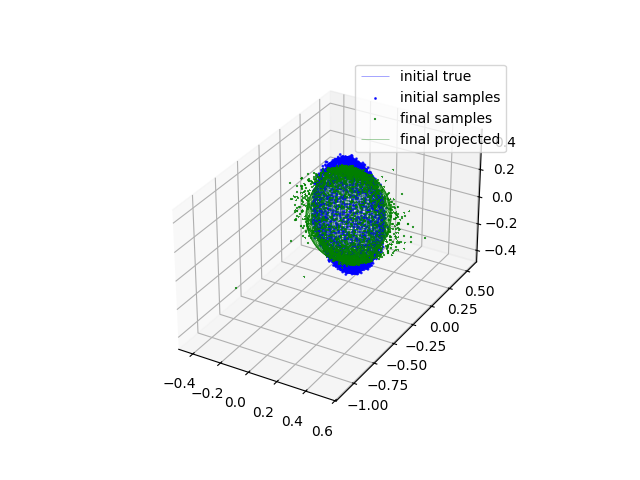

In [8]:
node = EllipsoidConstrainedProjectionNode(m)

n_batches = data.size(0)
x_init = data.view(n_batches, -1)
x_init.requires_grad = True
y_init, _ = node.solve(x_init)

history = [y_init]

x = x_init.clone()


class EllipseConstrainedProjectionFunction(DeclarativeFunction):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

class SqrtProductLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return torch.sqrt(input[:,0] * input[:,1] * input[:,2])

y_init = EllipseConstrainedProjectionFunction.apply(node, x_init)
sqrt_prod_loss = SqrtProductLoss()
history = [y_init]
x = x_init.clone().detach().requires_grad_(True)
torch_opt = torch.optim.SGD([x], lr=0.05)
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=torch_opt,
#                                                           mode='min',
#                                                           factor=0.8,
#                                                           patience=3,
#                                                           threshold=1e-4)

for i in range(60):
    torch_opt.zero_grad(set_to_none=True)
    y = EllipseConstrainedProjectionFunction.apply(node, x)
    history.append(y.detach().clone())
    if True:
        u = fit_ellipsoid(x.view(n_batches, 3, -1), p)
        print("y,u", y,u)
        a_hat = math.sqrt(1.0 / u[:,0])
        b_hat = math.sqrt(1.0 / u[:,1])
        c_hat = math.sqrt(1.0 / u[:,2])
        print("{:5d}: ellipsoid estimate ({:0.3}, {:0.3}, {:0.3}) has volume {:0.7} and surface area {:0.3}.".format(i, a_hat, b_hat, c_hat, ellipsoid_volume(a_hat, b_hat, c_hat), ellipsoid_surface_area(a_hat, b_hat, c_hat, p)))
    loss = sqrt_prod_loss(y)
    loss.backward()
    torch_opt.step()

    # lr_scheduler.step(loss)
    # current_lr = torch_opt.param_groups[0]['lr']
    # print(f"Iteration {i}: Current Learning Rate = {current_lr:.6f}")


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
kwargs = {
    'color': 'blue',   # Color of the wireframe
    'linestyle': '-',  # Line style (solid)
    'linewidth': 0.5,  # Line width
    'alpha': 0.5
}
plot_ellipsoid(ax, a, b, c, **kwargs)
ax.scatter(data[0, 0].numpy(), data[0, 1].numpy(), data[0, 2].numpy(), color='b', alpha=0.8, s=1)

final_data = x.reshape(1, 3, -1).detach()
ax.scatter(final_data[0, 0].numpy(), final_data[0, 1].numpy(), final_data[0, 2].numpy(), color='g', marker='+', alpha=0.8, s=1)

u = fit_ellipsoid(final_data, p)
a_hat = math.sqrt(1.0 / u[:,0])
b_hat = math.sqrt(1.0 / u[:,1])
c_hat = math.sqrt(1.0 / u[:,2])
kwargs = {
    'color': 'green',   # Color of the wireframe
    'linestyle': '-',  # Line style (solid)
    'linewidth': 0.5,  # Line width
    'alpha': 0.5
}
plot_ellipsoid(ax, a_hat, b_hat, c_hat, **kwargs)

print("Final ellipsoid ({:0.3}, {:0.3},{:0.3}) has volume {:0.7} and surface area {:0.3}.".format(a_hat, b_hat, c_hat, ellipsoid_volume(a_hat, b_hat, c_hat), ellipsoid_surface_area(a_hat, b_hat, c_hat, p)))
# plt.axis('square')
plt.legend(['initial true', 'initial samples', 'final samples', 'final projected'])
plt.show()

In [ ]:
r = math.sqrt(1/(4*math.pi))
condition = (final_data[0, 0]**2 + final_data[0, 1]**2 + final_data[0, 2]**2) < (r**2)

# Reshape the condition to match the tensor shape for indexing
mask = condition.unsqueeze(0).expand_as(final_data)

# Use the mask to index the tensor
filtered_data = final_data[mask].view(final_data.size(0), final_data.size(1), -1)

print(f"There are {len(filtered_data[0][0])} points inside the ellipsoid.")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
kwargs = {
    'color': 'blue',   # Color of the wireframe
    'linestyle': '-',  # Line style (solid)
    'linewidth': 0.5,  # Line width
    'alpha': 0.1
}
plot_ellipsoid(ax, a_hat, b_hat, c_hat, **kwargs)
ax.scatter(filtered_data[0, 0].numpy(), filtered_data[0, 1].numpy(), filtered_data[0, 2].numpy(), color='g', marker='+', alpha=0.8, s=1)
plt.show()
